In [8]:
import os
import pandas
import numpy as np

path='/tsukimi/datasets/Chiba/baseline/datalist/val.csv'

# read csv
df = pandas.read_csv(path, header=None)
df.columns = ['path', 'label']
df['label']=df['label'].map(lambda x: x.split('&'))
label_map={}
# count labels
for label in df['label']:
    for l in label:
        if l in label_map:
            label_map[l]+=1
        else:
            label_map[l]=1

In [12]:
label_map

{'climbing_on_side': 147,
 'running': 1569,
 'restrainer_interaction': 1180,
 'unsupported_rearing': 162,
 'interaction_with_partner': 323,
 'immobility': 44,
 'idle_actions': 71}

In [14]:
1569/sum(label_map.values())

0.44879862700228834

In [1]:
path='/tsukimi/datasets/Chiba/cut_videos_2label'

import os
from collections import defaultdict
label_map=defaultdict(list)
label_map_2=defaultdict(list)
# walk through all files
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.mov'):
            # parse filename
            label0=file.split('-')[0]
            label1=file.split('-')[1]
            file_path=os.path.join(root, file)
            label_map[label0].append(file_path)
            label_map[label1].append(file_path)
            
            label_combined=label0+'&'+label1
            label_map_2[label_combined].append(file_path)

In [2]:
for key in label_map.keys():
    print(key, len(label_map[key]))

interaction_with_partner 4098
running 9476
restrainer_interaction 7259
immobility 312
unsupported_rearing 905
idle_actions 463
climbing_on_side 789


In [52]:
label_map

defaultdict(list,
            {'interaction_with_partner': ['/tsukimi/datasets/Chiba/cut_videos_2label/8_S2_4T_RBG3_center.mov/interaction_with_partner-interaction_with_partner-66.72-67.65.mov',
              '/tsukimi/datasets/Chiba/cut_videos_2label/8_S2_4T_RBG3_center.mov/interaction_with_partner-interaction_with_partner-66.72-67.65.mov',
              '/tsukimi/datasets/Chiba/cut_videos_2label/8_S2_4T_RBG3_center.mov/interaction_with_partner-interaction_with_partner-128.288-129.56.mov',
              '/tsukimi/datasets/Chiba/cut_videos_2label/8_S2_4T_RBG3_center.mov/interaction_with_partner-interaction_with_partner-128.288-129.56.mov',
              '/tsukimi/datasets/Chiba/cut_videos_2label/8_S2_4T_RBG3_center.mov/interaction_with_partner-interaction_with_partner-93.1-106.07.mov',
              '/tsukimi/datasets/Chiba/cut_videos_2label/8_S2_4T_RBG3_center.mov/interaction_with_partner-interaction_with_partner-93.1-106.07.mov',
              '/tsukimi/datasets/Chiba/cut_videos_2lab

In [44]:
for key in label_map_2.keys():
    print(key, len(label_map_2[key]))

interaction_with_partner&interaction_with_partner 2049
running&running 2340
restrainer_interaction&running 1755
running&restrainer_interaction 1807
restrainer_interaction&restrainer_interaction 1437
immobility&running 80
restrainer_interaction&unsupported_rearing 178
unsupported_rearing&running 174
idle_actions&running 97
unsupported_rearing&restrainer_interaction 193
restrainer_interaction&idle_actions 110
running&unsupported_rearing 215
running&idle_actions 107
idle_actions&idle_actions 13
running&climbing_on_side 305
climbing_on_side&running 192
restrainer_interaction&immobility 61
climbing_on_side&restrainer_interaction 64
restrainer_interaction&climbing_on_side 93
unsupported_rearing&climbing_on_side 41
immobility&restrainer_interaction 51
running&immobility 64
immobility&immobility 8
idle_actions&restrainer_interaction 73
immobility&climbing_on_side 15
idle_actions&climbing_on_side 16
immobility&unsupported_rearing 2
idle_actions&unsupported_rearing 12
climbing_on_side&unsupporte

In [45]:
# split train val test
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict

label_file_map=defaultdict(list)
path='/tsukimi/datasets/Chiba/cut_videos_2label'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.mov'):
            parts=file.split('-')
            label0=parts[0]
            label1=parts[1]
            file_path=os.path.join(root, file)
            label_combined=label0+'&'+label1
            label_file_map[label_combined].append(file_path)

In [6]:
import random
import numpy as np

label_count_val=defaultdict(int)
label_map_count=defaultdict(int)
for key in label_map.keys():
    label_map_count[key]=len(label_map[key])
    label_count_val[key]=0
val_list=[]
# sort label_map_count
label_map_count=sorted(label_map_count.items(), key=lambda x: x[1])
# while each label in label_count_val is less than 50
while min(label_count_val.values())<80:
    # add from smallest to largest
    for key, value in label_map_count:
        while label_count_val[key]<80:
            # randomly choose a file from label_map
            idx=np.random.randint(0, len(label_map[key]))
            file_path=label_map[key][idx]
            label1=file_path.split('/')[-1].split('-')[0]
            label2=file_path.split('/')[-1].split('-')[1]
            # if label1 and label2 both smaller than 50, add to val_list
            if label_count_val[label1]<80 and label_count_val[label2]<80:
                val_list.append(file_path)
                label_count_val[label1]+=1
                label_count_val[label2]+=1
                label_map[label1].remove(file_path)
                label_map[label2].remove(file_path)
                # label_map_count[label1]-=1
                # label_map_count[label2]-=1

KeyboardInterrupt: 

In [7]:
label_c=defaultdict(int)
for val in val_list:
    label1=val.split('/')[-1].split('-')[0]
    label2=val.split('/')[-1].split('-')[1]
    label_c[label1]+=1
    label_c[label2]+=1
label_c

defaultdict(int,
            {'immobility': 80,
             'restrainer_interaction': 80,
             'running': 80,
             'climbing_on_side': 80,
             'unsupported_rearing': 44,
             'idle_actions': 80})

In [8]:
import pandas as pd
save_list=[]
for file in val_list:
    label1=file.split('/')[-1].split('-')[0]
    label2=file.split('/')[-1].split('-')[1]
    label_combined=label1+'&'+label2
    save_list.append([file, label_combined])
# convert to dataframe
df=pd.DataFrame(save_list)
save_path="/tsukimi/datasets/Chiba/baseline"
df.to_csv(os.path.join(save_path, 'val.csv'), index=False, header=False)

In [9]:
# save the rest items in label_map to train
save_list=[]
for key in label_map.keys():
    for file in label_map[key]:
        label1=file.split('/')[-1].split('-')[0]
        label2=file.split('/')[-1].split('-')[1]
        label_combined=label1+'&'+label2
        save_list.append([file, label_combined])
# calculate label distribution
label_count=defaultdict(int)
for file in save_list:
    label1=file[1].split('&')[0]
    label2=file[1].split('&')[1]
    label_count[label1]+=1
    label_count[label2]+=1
label_count

defaultdict(int,
            {'interaction_with_partner': 8036,
             'running': 18632,
             'restrainer_interaction': 14198,
             'unsupported_rearing': 1562,
             'idle_actions': 606,
             'climbing_on_side': 1258,
             'immobility': 304})

In [10]:
# convert to dataframe
df=pd.DataFrame(save_list)
save_path="/tsukimi/datasets/Chiba/baseline"
df.to_csv(os.path.join(save_path, 'train.csv'), index=False, header=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.2914162
-2.0293021


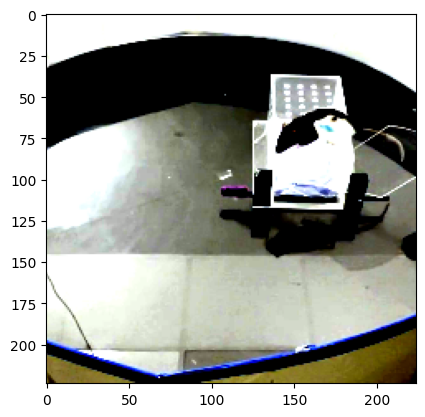

['restrainer_interaction&running', 'restrainer_interaction&running']
[2082, 2082]


In [34]:
import pickle
data_path='samples/sample_data.pkl'

# read data
with open(data_path, 'rb') as f:
    data=pickle.load(f)
# data[0][0].shape torch.Size([3, 16, 224, 224])
# show image data
import matplotlib.pyplot as plt
import torch
import numpy as np

# show image
def show_image(data):
    img=data.numpy()
    first_frame = img[:, 0, :, :]
    first_frame=np.transpose(first_frame, (1, 2, 0))
    # first_frame=first_frame* np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    print(first_frame.max())
    print(first_frame.min())
    plt.imshow(first_frame)
    plt.show()

show_image(data[0][0])
print(data[1])
print(data[2])

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.distributed import DistributedSampler

class WeightedDistributedSampler(Sampler):
    def __init__(self, dataset, num_replicas, rank, weight_function, replacement=True):
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.weight_function = weight_function
        self.replacement = replacement

        # Create a DistributedSampler to handle indexing
        self.dist_sampler = DistributedSampler(
            self.dataset,
            num_replicas=self.num_replicas,
            rank=self.rank,
            shuffle=True,
            seed=42
        )
        self.indices = list(self.dist_sampler)  # Obtain indices for this process

        # Calculate weights only for the indices this sampler handles
        self.reduced_weights = self.weight_function(self.dataset, self.indices)

    def __iter__(self):
        # Weighted sampling from the reduced indices
        if self.replacement:
            return iter(torch.multinomial(torch.tensor(self.reduced_weights, dtype=torch.float), len(self.indices), replacement=True).tolist())
        else:
            # No replacement, shuffle to ensure random order
            sampled_indices = torch.multinomial(torch.tensor(self.reduced_weights, dtype=torch.float), len(self.indices), replacement=False)
            return iter([self.indices[i] for i in sampled_indices])

    def __len__(self):
        return len(self.indices)

# Example weight function that computes weights based on some property of the data
def compute_weights(dataset, indices):
    # For example, weights could be inversely proportional to the class frequency (assuming class labels are the second column)
    class_counts = {}
    for index in indices:
        label = dataset[index][1]
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    weights = [1.0 / class_counts.get(dataset[index][1], 1) for index in indices]
    return weights

# Example dataset setup
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.randn(100, 3)  # 100 samples, 3 features each
        self.labels = torch.randint(0, 5, (100,))  # Random integer labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = MyDataset()

# Use the custom sampler
sampler = WeightedDistributedSampler(dataset, num_replicas=4, rank=0, weight_function=compute_weights)
loader = DataLoader(dataset, batch_size=10, sampler=sampler)

for data in loader:
    print(data)


[tensor([[-0.1639, -1.5425, -3.0695],
        [ 0.7000,  0.8541,  0.7599],
        [ 1.3441, -0.0237,  1.1445],
        [ 0.7430,  0.6078,  0.2831],
        [-1.0962,  0.6532,  0.1058],
        [ 1.6799,  0.2420,  0.2213],
        [ 0.6286, -0.0251,  1.0599],
        [ 0.4240,  0.5797, -0.9058],
        [ 1.3441, -0.0237,  1.1445],
        [ 1.6735,  0.2521, -0.3379]]), tensor([2, 0, 0, 0, 4, 2, 1, 2, 0, 0])]
[tensor([[-0.6804, -0.1714, -0.1979],
        [-1.0962,  0.6532,  0.1058],
        [ 0.1303,  0.0711, -0.4397],
        [ 0.7000,  0.8541,  0.7599],
        [ 1.3441, -0.0237,  1.1445],
        [ 0.6286, -0.0251,  1.0599],
        [-0.9577,  0.0751, -0.4678],
        [-1.0962,  0.6532,  0.1058],
        [ 0.6286, -0.0251,  1.0599],
        [-2.3684, -0.4524, -0.1086]]), tensor([2, 4, 0, 0, 0, 1, 4, 4, 1, 3])]
[tensor([[ 0.1271, -0.4774,  0.3150],
        [ 1.0346, -1.3961, -0.4618],
        [ 0.6286, -0.0251,  1.0599],
        [ 0.1303,  0.0711, -0.4397],
        [ 0.4240,  0.5797